# Unsupervised Learning Capstone
## Email Novelty Detection
###  Introduction

The purpose of this capstone is to identify the most unique emails based on text classification and Natural Language Processing using word2vec.  

### Data

The data used for this project is the Enron email corpus.  We will train this model and try to identify unique emails out of the data set.  Specifically, we look at the sent emails from each user.  This way, the texts can be labeled to be identified to unique users.

You can download the data from here:  https://www.kaggle.com/wcukierski/enron-email-dataset/data

I didn't do that, and I ultimately did it the hard way by downloading the originals and traversing the path.  The data in the link from Kaggle is already formatted for you, which would've made this whole thing a lot easier, but you live and learn.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import re
import glob
import email
from nltk.corpus import stopwords
import spacy
import nltk

In [2]:
# Utility function to clean text.
def text_cleaner(text):  
    text = re.sub(r'-',' ',text)
    text = re.sub("\n", " ", text)
    text = re.sub("~.*", "", text)
    text = re.sub('[^A-Za-z .-]+', ' ', text)
    text = re.sub('\.', '', text)
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    text = re.sub("Get Your Private, Free E mail from MSN Hotmail at", "", text)    
    text = re.sub("Forwarded by", "", text)
    return text

In [3]:
def get_entities(document):
    """Returns Named Entities using NLTK Chunking"""
    entities = []
    sentences = tokenize_sentences(document)
    # Part of Speech Tagging
    sentences = [nltk.pos_tag(sent) for sent in sentences]

    for tagged_sentence in sentences:
        for chunk in nltk.ne_chunk(tagged_sentence):
            if type(chunk) == nltk.tree.Tree:
                entities.append(' '.join([c[0] for c in chunk]).lower())

    return entities

In [4]:
def tokenize_sentences(document):
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    return sentences

In [5]:
# Here I am limiting this to 1000 emails.  NLP is extremely memory intensive and I could not run this on my computer without
# memory errors for the entire body of emails.

i = 0

directory = "C:\\Users\\kim\\Downloads\\enron_mail\\maildir"

fileList = [os.path.normcase(f)
                for f in os.listdir(directory)] 

stopWords = set(stopwords.words('english'))

NOUNS = ['NN', 'NNS', 'NNP', 'NNPS']

records = []

for f in fileList:
    sent_emails = "C:\\Users\\kim\\Downloads\\enron_mail\\maildir\\{0}\\sent".format(f) 
    try:
    
        for f1 in os.listdir(sent_emails):
            if i == 1000:
                break
            f1 = "C:\\Users\\kim\\Downloads\\enron_mail\\maildir\\{0}\\sent\\{1}".format(f, f1) 
            my_file = open(f1, 'r')
            text = my_file.read()
            
            b = email.message_from_string(text)
            if b.is_multipart():
                for payload in b.get_payload():
                    # if payload.is_multipart(): ...
                    text = payload.get_payload()
            else:
                text = b.get_payload()
            text = text_cleaner(text)
            words = nltk.tokenize.word_tokenize(text)
            words = [word.lower() for word in words if word not in stopWords]
            fdist = nltk.FreqDist(words)
            most_freq_nouns = [w for w, c in fdist.most_common(10)
                   if nltk.pos_tag([w])[0][1] in NOUNS]
            
            # Get Top 10 entities
            entities = get_entities(text)

            top_10_entities = [w for w, c in nltk.FreqDist(entities).most_common(10)]

            # Get the subject noun by looking at the intersection of top 10 entities
            # and most frequent nouns. It takes the first element in the list
            subject_nouns = [entity for entity in top_10_entities if entity.split()[0] in most_freq_nouns]
            i += 1
            record = [f, text, words, fdist, subject_nouns]
            records.append(record)
    except FileNotFoundError:
        continue

In [6]:
df = pd.DataFrame(records, columns=['user','text', 'words', 'fdist', 'subject_nouns'])

In [7]:
df.head()

,user,text,words,fdist,subject_nouns
0,allen-p,Phillip K Allen HOU ECT on PM Lucy Gonzalez s...,"[phillip, k, allen, hou, ect, pm, lucy, gonzal...","{'phillip': 1, 'k': 1, 'allen': 1, 'hou': 1, '...","[phillip, hou, pm lucy gonzalez]"
1,allen-p,Phillip K Allen HOU ECT on PM Enron admin FSD...,"[phillip, k, allen, hou, ect, pm, enron, admin...","{'phillip': 1, 'k': 1, 'allen': 1, 'hou': 1, '...","[executive impact, influence program]"
2,allen-p,Larry Just a note to touch base on the sagewoo...,"[larry, just, note, touch, base, sagewood, tow...","{'larry': 1, 'just': 1, 'note': 1, 'touch': 1,...","[larry, reagan lehmann, reagan]"
3,allen-p,Ina I scheduled a meeting with Jean Mrha tomor...,"[ina, i, scheduled, meeting, jean, mrha, tomor...","{'ina': 1, 'i': 1, 'scheduled': 1, 'meeting': ...","[ina, jean mrha]"
4,allen-p,Phillip K Allen HOU ECT on AM Jeff Richter AM...,"[phillip, k, allen, hou, ect, am, jeff, richte...","{'phillip': 2, 'k': 2, 'allen': 2, 'hou': 20, ...","[hou, exodus, seattle, seattle city light]"


In [8]:
# Sentiment Analysis with TextBlob -- EASY, right?!?!?

from textblob import TextBlob
final = []
for index, row in df.iterrows():
    b = TextBlob(row['text'])
    sentiment = b.sentiment.polarity
    f = [row['user'], row['text'], sentiment]
    final.append(f)

In [9]:
final = pd.DataFrame(final, columns=['user','text','sentiment'])
final.head()

,user,text,sentiment
0,allen-p,Phillip K Allen HOU ECT on PM Lucy Gonzalez s...,0.166667
1,allen-p,Phillip K Allen HOU ECT on PM Enron admin FSD...,0.158333
2,allen-p,Larry Just a note to touch base on the sagewoo...,0.041136
3,allen-p,Ina I scheduled a meeting with Jean Mrha tomor...,0.000000
4,allen-p,Phillip K Allen HOU ECT on AM Jeff Richter AM...,0.055796


In [10]:
sorted(final.sentiment)

[-1.0,
 -0.69999999999999984,
 -0.66666666666666663,
 -0.58333333333333337,
 -0.40000000000000002,
 -0.40000000000000002,
 -0.40000000000000002,
 -0.33333333333333331,
 -0.31666666666666665,
 -0.2857142857142857,
 -0.28333333333333333,
 -0.28333333333333333,
 -0.26666666666666666,
 -0.25555555555555554,
 -0.25,
 -0.25,
 -0.24999999999999992,
 -0.22222222222222218,
 -0.22222222222222218,
 -0.20833333333333331,
 -0.20833333333333331,
 -0.20000000000000004,
 -0.20000000000000001,
 -0.19444444444444442,
 -0.18888888888888888,
 -0.18333333333333335,
 -0.17916666666666667,
 -0.17592592592592593,
 -0.17222222222222219,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666666666666,
 -0.16666666

In [11]:
negative = final[final['sentiment']== -1]

In [12]:
negative

,user,text,sentiment
987,arnold-j,awfully close,-1.0


In [13]:
positive = final[final['sentiment']==1]

In [14]:
positive

,user,text,sentiment
258,allen-p,Andrea After reviewing Bryan Hull s resume I t...,1.0
929,arnold-j,best GUESS P L tonight is,1.0


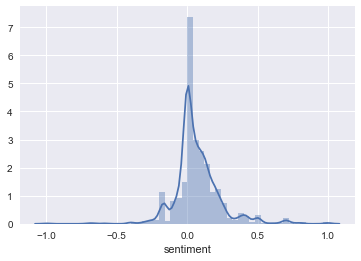

In [15]:
sns.distplot(final['sentiment'])

In [16]:
# Using SpaCy to turn each email into a SpaCy doc object and store it in a dataframe
# Once it's in a doc object format
nlp = spacy.load('en') 
df['doc'] = df['text'].apply(lambda x: nlp(x))

In [17]:
df.head()

,user,text,words,fdist,subject_nouns,doc
0,allen-p,Phillip K Allen HOU ECT on PM Lucy Gonzalez s...,"[phillip, k, allen, hou, ect, pm, lucy, gonzal...","{'phillip': 1, 'k': 1, 'allen': 1, 'hou': 1, '...","[phillip, hou, pm lucy gonzalez]","( , Phillip, K, Allen, HOU, ECT, on, PM, Lucy,..."
1,allen-p,Phillip K Allen HOU ECT on PM Enron admin FSD...,"[phillip, k, allen, hou, ect, pm, enron, admin...","{'phillip': 1, 'k': 1, 'allen': 1, 'hou': 1, '...","[executive impact, influence program]","( , Phillip, K, Allen, HOU, ECT, on, PM, Enron..."
2,allen-p,Larry Just a note to touch base on the sagewoo...,"[larry, just, note, touch, base, sagewood, tow...","{'larry': 1, 'just': 1, 'note': 1, 'touch': 1,...","[larry, reagan lehmann, reagan]","(Larry, Just, a, note, to, touch, base, on, th..."
3,allen-p,Ina I scheduled a meeting with Jean Mrha tomor...,"[ina, i, scheduled, meeting, jean, mrha, tomor...","{'ina': 1, 'i': 1, 'scheduled': 1, 'meeting': ...","[ina, jean mrha]","(Ina, I, scheduled, a, meeting, with, Jean, Mr..."
4,allen-p,Phillip K Allen HOU ECT on AM Jeff Richter AM...,"[phillip, k, allen, hou, ect, am, jeff, richte...","{'phillip': 2, 'k': 2, 'allen': 2, 'hou': 20, ...","[hou, exodus, seattle, seattle city light]","( , Phillip, K, Allen, HOU, ECT, on, AM, Jeff,..."


In [18]:
all_documents = []

for index, row in df.iterrows():
    doc = row['doc']
    for index2, row2 in df.iterrows():
        doc2 = row2['doc']
        similarity = doc.similarity(doc2)
        all_documents.append([row['user'], row['text'], similarity, row2['user'], row2['text']])  

In [19]:
all_documents = pd.DataFrame(all_documents, columns=['user','text','similarity', 'user2', 'text2'])

In [20]:
all_documents.sort_values(by='similarity')

,user,text,similarity,user2,text2
314987,allen-p,Phillip K Allen HOU ECT on AM To Phillip K Al...,-0.173402,arnold-j,awfully close
987314,arnold-j,awfully close,-0.173402,allen-p,Phillip K Allen HOU ECT on AM To Phillip K Al...
411987,allen-p,Phillip K Allen HOU ECT on AM Susan J Mara EN...,-0.157245,arnold-j,awfully close
987411,arnold-j,awfully close,-0.157245,allen-p,Phillip K Allen HOU ECT on AM Susan J Mara EN...
987928,arnold-j,awfully close,-0.146017,arnold-j,John Arnold HOU ECT on PM Schaefer Matthew MS...
928987,arnold-j,John Arnold HOU ECT on PM Schaefer Matthew MS...,-0.146017,arnold-j,awfully close
460987,allen-p,Phillip K Allen HOU ECT on AM From Steven J K...,-0.130463,arnold-j,awfully close
987460,arnold-j,awfully close,-0.130463,allen-p,Phillip K Allen HOU ECT on AM From Steven J K...
399987,allen-p,Phillip K Allen HOU ECT on AM Robert Neustaed...,-0.123424,arnold-j,awfully close
987399,arnold-j,awfully close,-0.123424,allen-p,Phillip K Allen HOU ECT on AM Robert Neustaed...


The two texts below are the least similar.  This finds the most novel, unique emails in the body of emails compared to each other.

In [21]:
all_documents.iloc[987314]['text']

'awfully close'

In [22]:
all_documents.iloc[987314]['text2']

' Phillip K Allen HOU ECT on AM To Phillip K Allen HOU ECT ECT cc Subject Current Gas Desk List Hope this helps This is the current gas desk list that I have in my personal address book Call me with any questions Erika GROUP East Desk Basics Group name East Desk Group type Multi purpose Description Members Matthew B Fleming HOU EES James R Barker HOU EES Barend VanderHorst HOU EES Jay Blaine HOU EES Paul Tate HOU EES Alain Diza HOU EES Rhonda Smith HOU EES Christina Bangle HOU EES Sherry Pendegraft HOU EES Marde L Driscoll HOU EES Daniel Salinas HOU EES Sharon Hausinger HOU EES Joshua Bray HOU EES James Wiltfong HOU EES Owners Erika Dupre HOU EES Administrators Erika Dupre HOU EES Foreign directory sync allowed Yes GROUP West Desk Basics Group name West Desk Group type Multi purpose Description Members Jesus Guerra HOU EES Monica Roberts HOU EES Laura R Arnold HOU EES Amanda Boettcher HOU EES C Kyle Griffin HOU EES Jess Hewitt HOU EES Artemio Muniz HOU EES Eugene Zeitz HOU EES Brandon 

### Conclusion and Further Work
Using SpaCy makes document comparison very easy.  Using this to find outliers in text could be used in the field of CyberSecurity to compare users to themselves.  Once you compare users to themselves, you would have a baseline of thier language.  A very unique and also very negative text could be an indicator that a user is disgruntled.  